# Food Segmentation 
## UNIMIB2016 Food Database
- http://www.ivl.disco.unimib.it/activities/food-recognition/

## 라이브러리 임포트

In [ ]:
# 기본 라이브러리
import os
import json
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

# 이미지 처리 라이브러리
import cv2
import skimage
from skimage.transform import rotate
from skimage.draw import polygon2mask
# 시드
from numpy.random import seed

# 텐서플로 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import load_img,array_to_img, img_to_array

#케라스
import keras
from keras.models import Model,load_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Input, Conv2D, Conv2DTranspose,AveragePooling2D, MaxPool2D ,UpSampling2D,LeakyReLU, concatenate, Dropout,BatchNormalization,Activation

In [ ]:
# 시드설정
seed(123)
tf.random.set_seed(123)

In [ ]:
# 구글 드라이브 임포트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_root = "/content/drive/MyDrive/sec4_project/food/"

## 이미지 전처리

In [ ]:
# annotation.json 파일로 마스크 생성하기 
# 3개의 폴더 데이터 마스크 생성예정
modes = ['train', 'val', 'test']
# 해당 경로의 annotation.json 파일 열기 
for mode in modes:
    ann_file = os.path.join("/content/drive/MyDrive/sec4_project/food/{}".format(mode), "annotation.json")
    anns = json.load(open(ann_file))
    # 각 폴더별 마스크 숫자 
    print(mode, len(anns))
    # 경로 표기 
    print(ann_file[:-15])
# 각 경로별 마스크 이미지 불러와서 해당 이미지 크기대로 마스크 어레이 생성
    for img_name, ann in anns.items():
        num_instance = len(ann)
        img_file = os.path.join(ann_file[:-15], "{}.jpg".format(img_name))
        img_arr = cv2.imread(img_file)
        img_h, img_w, img_c = img_arr.shape
        cv2.imwrite("tmp_IMG.png", img_arr)
        mask_arr = np.zeros((img_h, img_w), dtype=np.uint8)
       # 해당 이미지 명 및 크기 표기 
        print("IMG: ", img_name, img_arr.shape)
      # 마스크 어레이를 이미지로 변환하여 저장 
        for ann_inst in ann:
            poly_dict = list(ann_inst.values())[0]
            poly_pts = poly_dict["BR"]
            rr, cc = skimage.draw.polygon(poly_pts[1::2], poly_pts[::2])
            rr = (img_h-1) - rr
            cc = (img_w-1) - cc
            mask_arr[rr, cc] = 150
            cv2.imwrite(ann_file[:-16]+'_mask/'+"{}m.png".format(img_name), mask_arr)
        exit()

train 722
/content/drive/MyDrive/sec4_project/food/train/
IMG:  20151211_141807 (2448, 3264, 3)
IMG:  20151203_121733 (2448, 3264, 3)
IMG:  20151221_123848 (2448, 3264, 3)
IMG:  20151221_135140 (2448, 3264, 3)
IMG:  20151204_131528 (2448, 3264, 3)
IMG:  20151130_115806 (3264, 2448, 3)
IMG:  20151127_130327 (3264, 2448, 3)
IMG:  20151204_123241 (2448, 3264, 3)
IMG:  20151221_131407 (2448, 3264, 3)
IMG:  20151204_121329 (2448, 3264, 3)
IMG:  20151211_121957 (3264, 2448, 3)
IMG:  20151204_133312 (2448, 3264, 3)
IMG:  20151221_132902 (2448, 3264, 3)
IMG:  20151221_114009 (2448, 3264, 3)
IMG:  20151221_131046 (2448, 3264, 3)
IMG:  20151211_113606 (3264, 2448, 3)
IMG:  20151211_115944 (2448, 3264, 3)
IMG:  20151204_124018 (2448, 3264, 3)
IMG:  20151130_114034 (3264, 2448, 3)
IMG:  20151204_133409 (2448, 3264, 3)
IMG:  20151204_123621 (2448, 3264, 3)
IMG:  20151221_130923 (2448, 3264, 3)
IMG:  20151221_113350 (2448, 3264, 3)
IMG:  20151204_120442 (2448, 3264, 3)
IMG:  20151204_131821 (2448, 3

In [ ]:
# 각 이미지 경로설정
train_dir = '/content/drive/MyDrive/sec4_project/food/train'
train_mask_dir = '/content/drive/MyDrive/sec4_project/food/train_mask'
val_dir = '/content/drive/MyDrive/sec4_project/food/val'
val_mask_dir = '/content/drive/MyDrive/sec4_project/food/val_mask'
test_dir = '/content/drive/MyDrive/sec4_project/food/test'
test_mask_dir = '/content/drive/MyDrive/sec4_project/food/test_mask'

In [ ]:
# 이미지와 마스크이미지 불러와서 순서 정렬을 통해 인덱스로 이미지 처리
train= os.listdir(train_dir)
mask_train= os.listdir(train_mask_dir)
val= os.listdir(val_dir)
mask_val= os.listdir(val_mask_dir)
test= os.listdir(test_dir)
mask_test= os.listdir(test_mask_dir)
train.sort()
mask_train.sort()
val.sort()
mask_val.sort()
test.sort()
mask_test.sort()

In [ ]:
# 이미지 받아올 어레이 생성
train_arr = np.zeros((len(train[:-1]), 256, 256, 3), dtype = np.float32)
train_mask_arr = np.zeros((len(os.listdir(train_mask_dir)), 256, 256, 1), dtype = np.float32)
val_arr = np.zeros((len(val[:-1]), 256, 256, 3), dtype = np.float32)
val_mask_arr = np.zeros((len(os.listdir(val_mask_dir)), 256, 256, 1), dtype = np.float32)
test_arr = np.zeros((len(test[:-1]), 256, 256, 3), dtype = np.float32)
test_mask_arr = np.zeros((len(os.listdir(test_mask_dir)), 256, 256, 1), dtype = np.float32)

In [ ]:
# 이미지 어레이에 각 이미지 값 입력 및 정규화(train)
for index in range(len(train[:-1])):
    img = load_img(os.path.join(train_dir,train[index]), target_size = (256, 256, 3))
    train_arr[index] = img_to_array(img)

for index in range(len(os.listdir(train_mask_dir))):
    img = load_img(os.path.join(train_mask_dir, mask_train[index]), target_size = (256, 256, 1), color_mode="grayscale" )
    train_mask_arr[index] = img_to_array(img)


train_arr /= 255.
train_mask_arr /= 255.

x_train = train_arr
y_train = train_mask_arr

print(len(x_train))
print(len(y_train))

722
722


In [ ]:
# 이미지 어레이에 각 이미지 값 입력 및 정규화(val)
for index in range(len(val[:-1])):
    img = load_img(os.path.join(val_dir,val[index]), target_size = (256, 256, 3))
    val_arr[index] = img_to_array(img)

for index in range(len(os.listdir(val_mask_dir))):
    img = load_img(os.path.join(val_mask_dir, mask_val[index]), target_size = (256, 256, 1), color_mode="grayscale" )
    val_mask_arr[index] = img_to_array(img)


val_arr /= 255.
val_mask_arr /= 255.

x_val = val_arr
y_val = val_mask_arr

print(len(x_val))
print(len(y_val))

192
192


In [ ]:
# 이미지 어레이에 각 이미지 값 입력 및 정규화(test)
for index in range(len(test[:-1])):
    img = load_img(os.path.join(test_dir,test[index]), target_size = (256, 256, 3))
    test_arr[index] = img_to_array(img)

for index in range(len(os.listdir(test_mask_dir))):
    img = load_img(os.path.join(test_mask_dir, mask_test[index]), target_size = (256, 256, 1), color_mode="grayscale" )
    test_mask_arr[index] = img_to_array(img)


test_arr /= 255.
test_mask_arr /= 255.

x_test = test_arr
y_test = test_mask_arr

print(len(x_test))
print(len(y_test))

48
48


In [ ]:
# 마스크이미지가 반대로 되어있어 180도 회전처리
y_train_rotate=[]
for i in range(len(y_train)):
  y_train_rotate.append(rotate(y_train[i], 180))
y_train_rotate= np.array(y_train_rotate)

In [ ]:
# 마스크이미지가 반대로 되어있어 180도 회전처리
y_val_rotate=[]
for i in range(len(y_val)):
  y_val_rotate.append(rotate(y_val[i], 180))
y_val_rotate= np.array(y_val_rotate)

In [ ]:
# 마스크이미지가 반대로 되어있어 180도 회전처리
y_test_rotate=[]
for i in range(len(y_test)):
  y_test_rotate.append(rotate(y_test[i], 180))
y_test_rotate= np.array(y_test_rotate)

In [ ]:
# 각 마스크 이미지 확인
print(len(y_train_rotate))
print(len(y_val_rotate))
print(len(y_test_rotate))

722
192
48


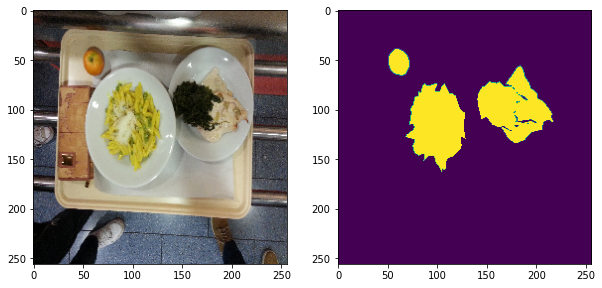

In [ ]:
import matplotlib.pyplot as plt
f = plt.figure(figsize=(10,10))
f.add_subplot(1,2, 1)
plt.imshow(x_train[25])
f.add_subplot(1,2, 2)
plt.imshow(np.squeeze(y_train_rotate[25]))
plt.show(block=True)

## 모델생성

In [ ]:
# 컨볼루션 함수 
def conv_block(inputs,n_filters,max_pool=True):
    x = Conv2D(n_filters,3,padding='same',kernel_initializer='he_normal',use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(n_filters,3,padding='same',kernel_initializer='he_normal',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    skip = x
    if max_pool:
        next_layer = MaxPool2D()(x)
    else:
        next_layer = x
    return next_layer, skip

# 업샘플링 함수 
def up_block(reg_inputs,skip_inputs,n_filters):
    x = Conv2DTranspose(n_filters,3,2,padding='same')(reg_inputs)
    x = concatenate([x,skip_inputs],axis=3)
    x = conv_block(x,n_filters,max_pool=False)[0]
    return x
    

In [ ]:
# UNET 함수 
def unet(input_size=(256,256,3),number_of_classes=1):
    inputs = Input(shape=input_size)
    cb1 = conv_block(inputs,32)
    cb2 = conv_block(cb1[0],64)
    cb3 = conv_block(cb2[0],128)
    cb4 = conv_block(cb3[0],256)
    cb5 = conv_block(cb4[0],512,max_pool=False)
    
    up1 = up_block(cb5[0],cb4[1],256)
    up2 = up_block(up1,cb3[1],128)
    up3 = up_block(up2,cb2[1],64)
    up4 = up_block(up3,cb1[1],32)
    
    conv1 = Conv2D(32,3,padding='same',kernel_initializer='he_normal',use_bias=False)(up4)
    bn = BatchNormalization()(conv1)
    lrl = LeakyReLU(0.2)(bn)
    outputs = Conv2D(number_of_classes,1,padding='same',activation='sigmoid')(lrl)
    
    unet = Model(inputs=inputs,outputs=outputs)
    return unet

In [ ]:
# 모델 생성
model = unet()

In [ ]:
# 모델 컴파일
model.compile(optimizer=keras.optimizers.Adam(1e-3),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])

In [ ]:
# 모델 구조 확인
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

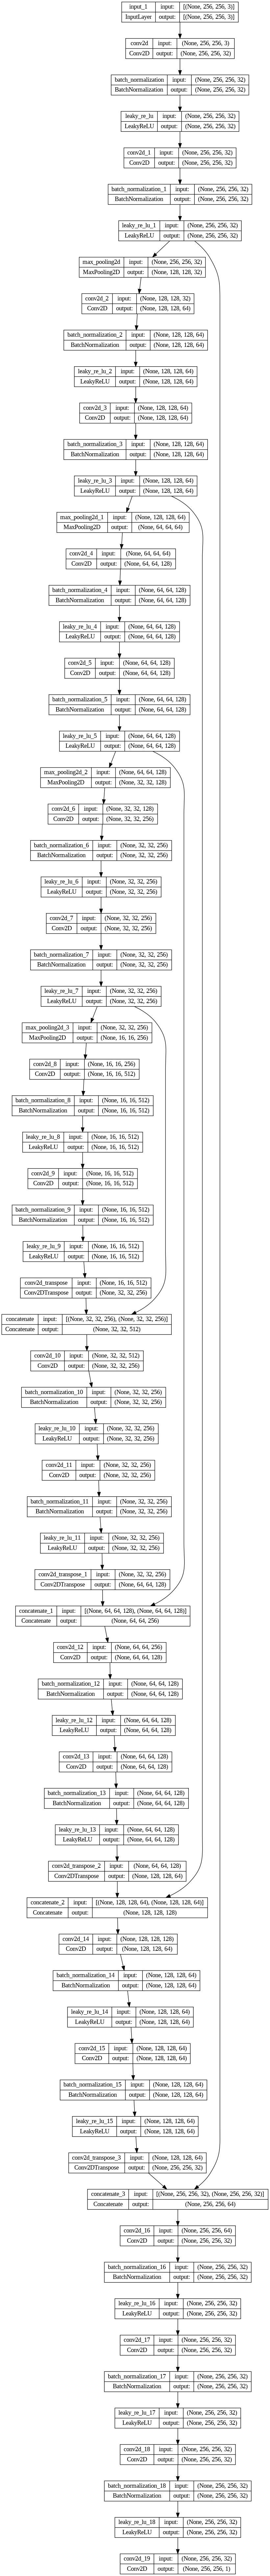

In [ ]:
#모델 구조 시각화
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# 체크포인트 설정 
checkpointer = ModelCheckpoint(filepath=data_root+'foodmask.h5', verbose=1,mode='auto', monitor='val_loss',save_best_only=True)

In [ ]:
# 얼리스타핑 설정
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'auto')

In [ ]:
# 모델 학습
history = model.fit(x_train,y_train_rotate,batch_size=8,epochs=50,validation_data=(x_val, y_val_rotate), callbacks=[checkpointer,early_stopping] )

Epoch 1/50


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


91/91 [==============================] - ETA: 0s - loss: 0.3076 - accuracy: 0.8778
Epoch 1: val_loss improved from inf to 0.32794, saving model to /content/drive/MyDrive/sec4_project/food/foodmask.h5
91/91 [==============================] - 44s 335ms/step - loss: 0.3076 - accuracy: 0.8778 - val_loss: 0.3279 - val_accuracy: 0.8724
Epoch 2/50
91/91 [==============================] - ETA: 0s - loss: 0.1992 - accuracy: 0.8990
Epoch 2: val_loss improved from 0.32794 to 0.20291, saving model to /content/drive/MyDrive/sec4_project/food/foodmask.h5
91/91 [==============================] - 22s 242ms/step - loss: 0.1992 - accuracy: 0.8990 - val_loss: 0.2029 - val_accuracy: 0.9025
Epoch 3/50
91/91 [==============================] - ETA: 0s - loss: 0.1751 - accuracy: 0.8992
Epoch 3: val_loss improved from 0.20291 to 0.19954, saving model to /content/drive/MyDrive/sec4_project/food/foodmask.h5
91/91 [==============================] - 22s 244ms/step - loss: 0.1751 - accuracy: 0.8992 - val_loss: 0.19

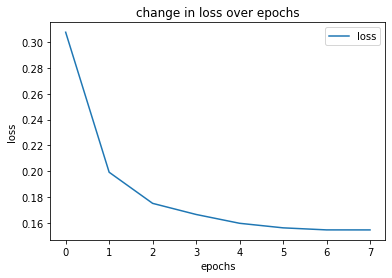

In [ ]:
# loss 그래프 시각화 
x = [i for i in range(8)]
plt.plot(x,history.history['loss'])
plt.title('change in loss over epochs')
plt.legend(['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
# 예측 진행 
predictions = model.predict(x_test)

2/2 [==============================] - 6s 2s/step


In [ ]:
# x_test 마스크 어레이 생성
def create_mask(predictions,input_shape=(256,256,1)):
    mask = np.zeros(input_shape)
    mask[predictions>0.5] = 1
    return mask

In [ ]:
# 인풋이미지 , 실제 마스크, 예측마스크, 예측마스크+인풋이미지 시각화 
def plot_results_for_one_sample(sample_index):
    mask = create_mask(predictions[sample_index])
    f = plt.figure(figsize=(20,20))
    f.add_subplot(1,4,1)
    plt.title('Input image')
    plt.imshow(x_test[sample_index])
    f.add_subplot(1,4,2)
    plt.title('Real mask')
    plt.imshow(np.squeeze(y_test_rotate[sample_index]))
    f.add_subplot(1,4,3)
    plt.title('Predicted mask')
    plt.imshow(np.squeeze(mask))
    f.add_subplot(1,4,4)
    plt.title("Mask + image")
    plt.imshow(x_test[sample_index]*mask)

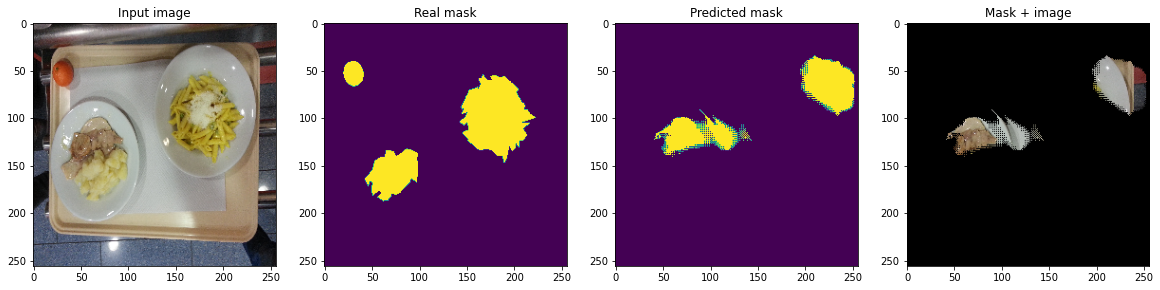

In [ ]:
plot_results_for_one_sample(0)

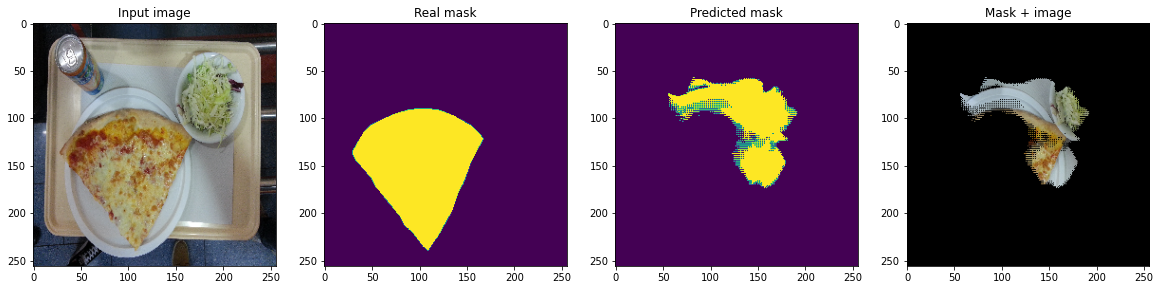

In [ ]:
plot_results_for_one_sample(1)

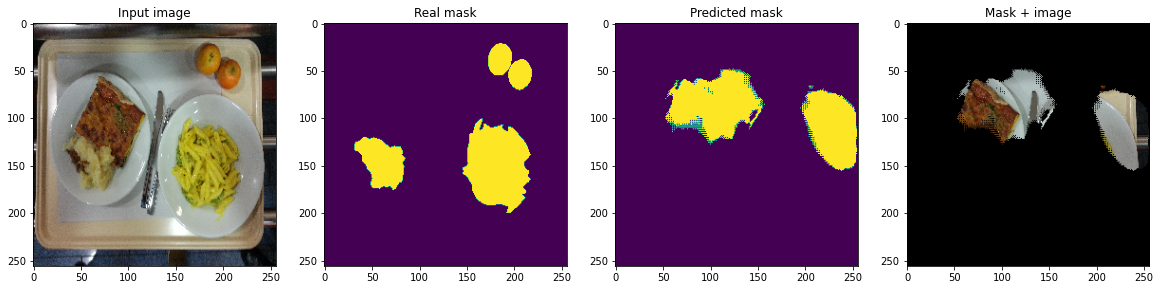

In [ ]:
plot_results_for_one_sample(2)

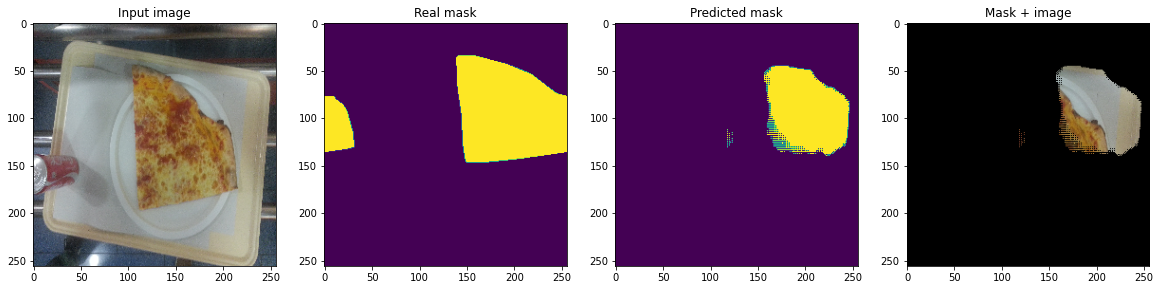

In [ ]:
plot_results_for_one_sample(3)

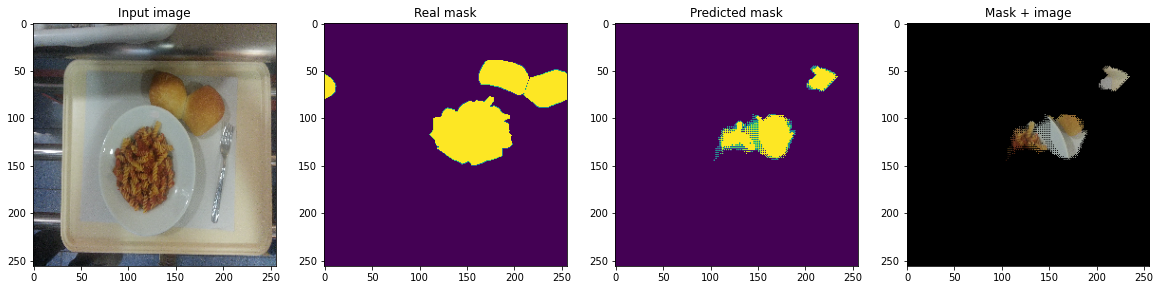

In [ ]:
plot_results_for_one_sample(4)